In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/cleaneddata/cleaned_train_copy.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import label_binarize

dataset = pd.read_csv(base_path)
dataset.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
dataset.drop(['age_group','id'], axis=1, inplace=True)

In [ ]:
dataset.head()

In [ ]:
X, y = dataset.drop(columns=['sii']), dataset['sii']  # Replace 'sii' with target column
feature_variances = np.var(X, axis=0)
print(f"Feature Variances:\n{feature_variances}\n")

High Variance Features:

SDS-SDS_Total_T (159.71): This feature has the highest variance and contributes significantly to the dataset's variability.
CGAS_Score (118.72): Another highly variable feature that might be essential for modeling.
Physical-BMI (22.18): Moderate variance, still meaningful.
Moderate Variance Features:

Basic_Demos-Age (11.71): Captures decent variability, likely important.
PreInt_EduHx-computerinternet_hoursday (1.16): Lower but non-negligible variance.
BIA_Activity_Level (1.06): Just above the threshold for near-zero variance.
Low Variance Features:

Basic_Demos-Sex (0.23): Minimal variability; likely a categorical or binary feature.
Fitness_Combined_Score (0.059): Very low variance; possibly not useful.
Physical_Composite_Index (0.00027): Extremely low variance, likely constant or nearly constant.

In [ ]:

variance_threshold = 0.1

plt.figure(figsize=(10, 6))
plt.bar(feature_variances.index, feature_variances.values)
plt.axhline(y=variance_threshold, color='r', linestyle='--', label="Variance Threshold")
plt.xticks(rotation=45, ha="right")
plt.title("Feature Variance Distribution")
plt.ylabel("Variance")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Get the column names of features with variance above the threshold
selected_features = feature_variances[feature_variances > 0.1].index

# Filter the data for high-variance features
X_high_variance = X[selected_features]  # Assumes X is a DataFrame with named columns

print(f"Selected High Variance Features:\n{selected_features}\n")
print(f"Reduced Feature Set Shape: {X_high_variance.shape}")


In [ ]:
# Pairwise distances and PCA
from sklearn.metrics import pairwise_distances

pairwise_dist = pairwise_distances(X_high_variance)
print(f"Pairwise Distances:\n{pairwise_dist}\n")

In [ ]:
# PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_high_variance)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (PCA): {explained_variance}")
print(f"Cumulative Explained Variance: {np.cumsum(explained_variance)}")

In [ ]:
# Visualize original vs scaled features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before scaling
axes[0].boxplot(X.values, vert=False)
axes[0].set_title("Original Features Distribution")

# After scaling
axes[1].boxplot(X_scaled, vert=False)
axes[1].set_title("Scaled Features Distribution")

plt.tight_layout()
plt.show()


In [ ]:
# Visualize PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("PCA Visualization (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Target Variable")
plt.show()

In [ ]:
# 3D Plot of PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap="viridis", s=50, alpha=0.7)
plt.title("3D Plot of PCA Components (PC1, PC2, PC3)")
plt.colorbar(sc, label="Target Variable")
plt.show()

In [ ]:
# Scree Plot for individual explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color="skyblue", edgecolor="black")
plt.title("Scree Plot (Explained Variance by Each Principal Component)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# Other Dimensionality Reduction Techniques
# MDS
from sklearn.manifold import MDS, TSNE, Isomap
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("MDS Visualization")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.colorbar(label="Target Variable")
plt.show()

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label="Target Variable")
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne.fit_transform(X_high_variance)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], 
    c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7
)

# Titles and labels
ax.set_title("t-SNE 3D Visualization")
ax.set_xlabel("t-SNE1")
ax.set_ylabel("t-SNE2")
ax.set_zlabel("t-SNE3")

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Target Variable")
plt.show()


In [ ]:
# Iso-map
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("Iso-Map Visualization")
plt.xlabel("Iso-Map1")
plt.ylabel("Iso-Map2")
plt.colorbar(label="Target Variable")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
# Naive Bayes Baseline
X_train, X_test, y_train, y_test = train_test_split(X_high_variance, y, test_size=0.3, random_state=42, stratify=y)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

The results indicate some improvement in classifying the minority classes, but the overall performance still reflects challenges in dealing with the class imbalance, especially for classes 1.0, 2.0, and 3.0

Class 0.0 (Majority Class):
Good precision, recall, and F1-score, as expected, since it's overrepresented.
Class 1.0 and 2.0 (Minority Classes):
Precision and recall are low, indicating difficulty in distinguishing these classes.
Class 3.0 (Highly Minority):
Recall is high but precision is very poor, likely due to oversampling by SMOTE leading to overfitting for this class.

Recommendations and Updates
Advanced Resampling Strategy:
Instead of plain SMOTE, use SMOTE-Tomek or ADASYN, which refine synthetic sample generation to reduce noise.
Hyperparameter Tuning:
Adjust SVM parameters (C, gamma, kernel) using GridSearchCV or RandomizedSearchCV to find optimal values.
Custom Kernel:
Experiment with a polynomial or sigmoid kernel to improve separability.
Ensemble Techniques:
Combine SVM with other classifiers (e.g., Random Forest, Gradient Boosting) using an ensemble method like voting or stacking.
Evaluation Metrics:
Visualize precision-recall and ROC curves per class.
Data Preprocessing:
Apply feature selection or engineering to better separate the minority classes.
Class-Specific Threshold Tuning:
Adjust decision thresholds for each class based on ROC curves to balance precision and recall.

In [ ]:
X, y = dataset.drop(columns=['sii']), dataset['sii']  # Replace 'sii' with target column
scaler = StandardScaler()
X_std = scaler.fit_transform(X_high_variance)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)
# Step 1: Advanced Resampling with SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 2: Hyperparameter Tuning for SVM
param_grid = {
    'C': [1],
    'gamma': [0.7],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)



In [ ]:
# Step 2: Hyperparameter Tuning for SVM
param_grid = {
    'C': [1],
    'gamma': [0.7],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': [None, 'balanced']
}
grid_search1 = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)

grid_search1.fit(X_train, y_train)
best_params1 = grid_search1.best_params_
print("Best Parameters:", best_params1)

In [ ]:
# Train SVM with best parameters
svm_model = SVC(**best_params, probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)
svm_model1 = SVC(**best_params1, probability=True, random_state=42)
svm_model1.fit(X_train, y_train)


In [ ]:
# Step 3: Analyze Support Vectors
support_vectors = svm_model.support_vectors_
num_support_vectors = len(support_vectors)
support_vector_indices = svm_model.support_
print(f"Number of Support Vectors: {num_support_vectors}")
print(f"Support Vector Indices: {support_vector_indices}")

support_vectors1 = svm_model1.support_vectors_
num_support_vectors1 = len(support_vectors1)
support_vector_indices1 = svm_model.support_
print(f"Number of Support Vectors: {num_support_vectors1}")
print(f"Support Vector Indices: {support_vector_indices1}")

In [ ]:
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)

y_pred1 = svm_model.predict(X_test)
y_prob1 = svm_model.predict_proba(X_test)

In [ ]:
# Evaluate Precision-Recall and ROC Curves for each class
plt.figure(figsize=(10, 8))
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))


In [ ]:
# Updated Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="coolwarm", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
roc_auc_scores = roc_auc_score(y_test_binarized, y_prob, average=None)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



In [ ]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Classification Report:\n", classification_report(y_test, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))

In [ ]:
import joblib

# Assuming 'wclf' is your trained model
model_path = '/kaggle/working/svm_model.pkl'

# Save the trained model to the specified path
joblib.dump(svm_model, model_path)


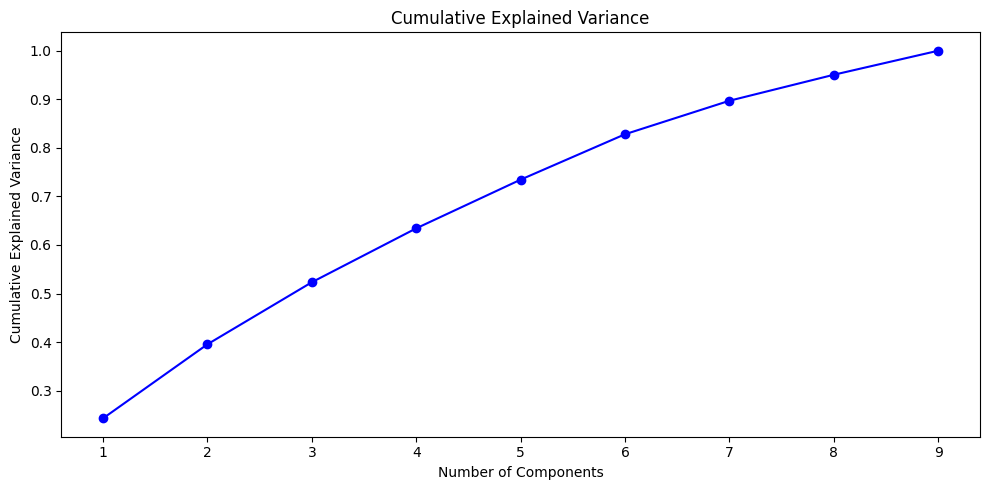

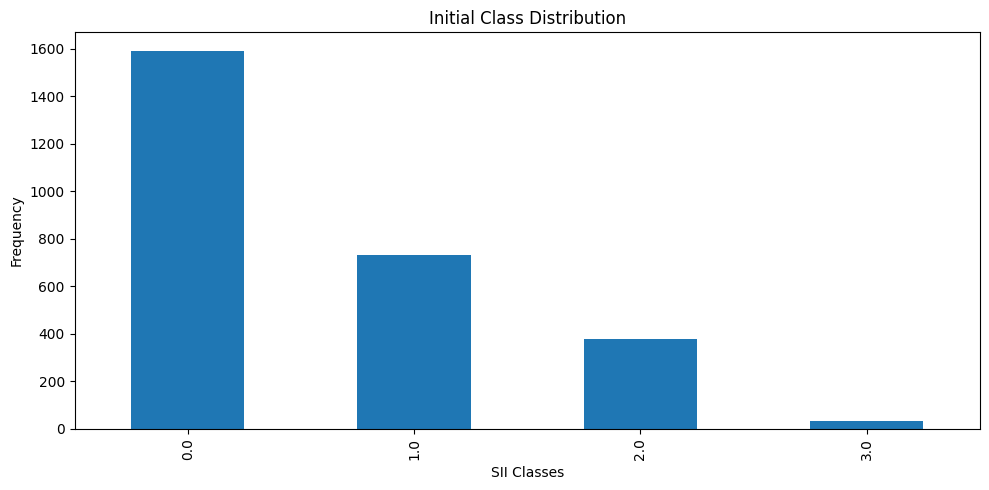


LINEAR Kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       318
         1.0       0.00      0.00      0.00       146
         2.0       0.00      0.00      0.00        75
         3.0       0.00      0.00      0.00         7

    accuracy                           0.58       546
   macro avg       0.15      0.25      0.18       546
weighted avg       0.34      0.58      0.43       546



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


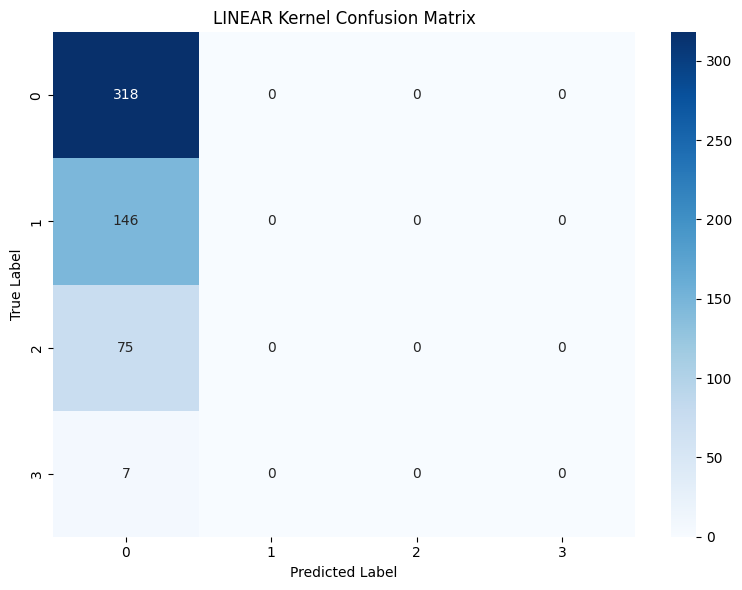

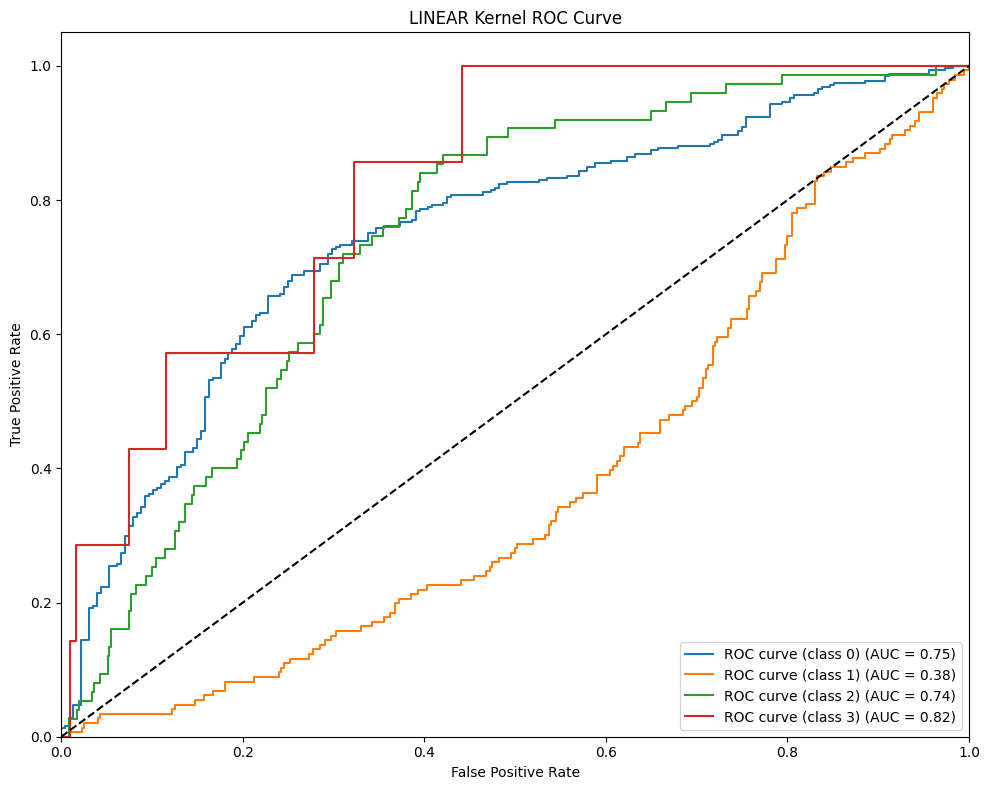

<Figure size 1000x800 with 0 Axes>

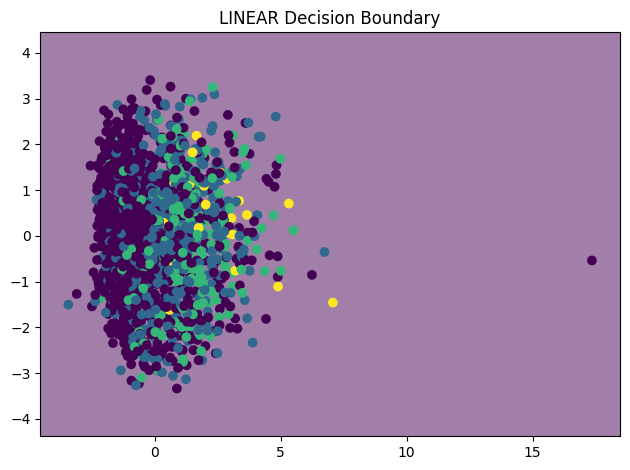


POLY Kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       318
         1.0       0.00      0.00      0.00       146
         2.0       0.00      0.00      0.00        75
         3.0       0.00      0.00      0.00         7

    accuracy                           0.58       546
   macro avg       0.15      0.25      0.18       546
weighted avg       0.34      0.58      0.43       546



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


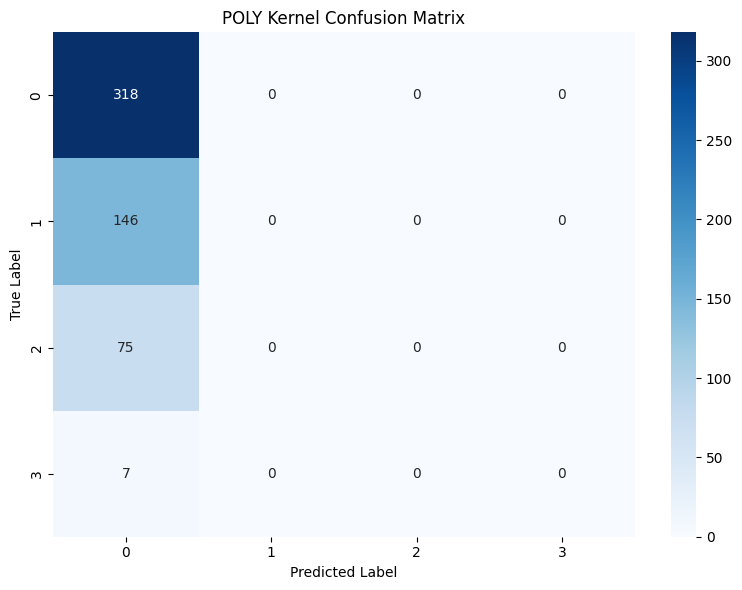

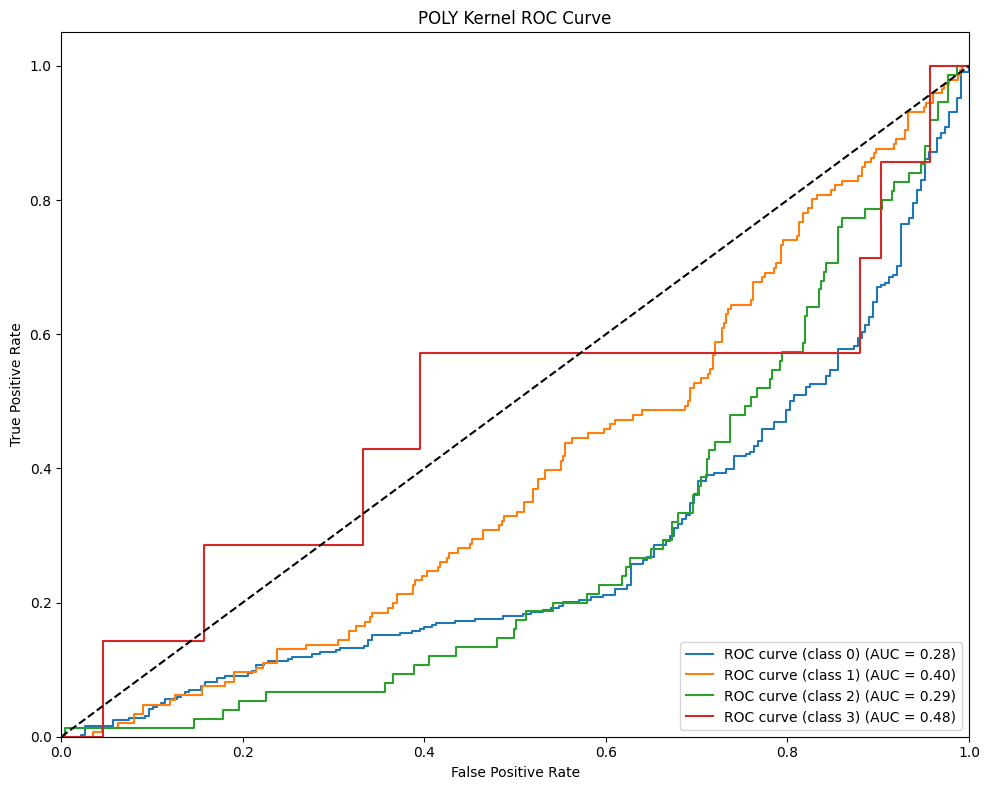

<Figure size 1000x800 with 0 Axes>

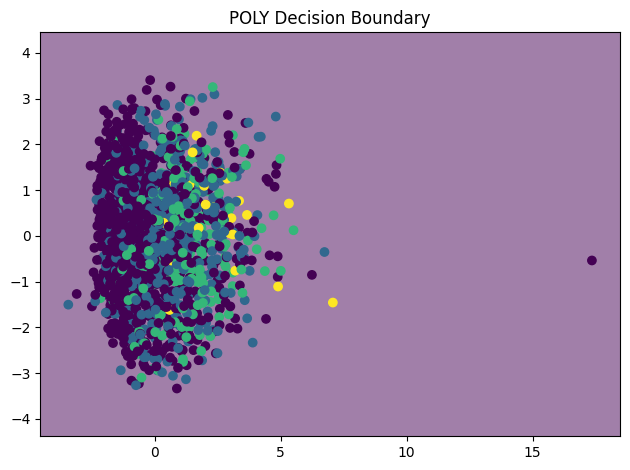


RBF Kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.94      0.74       318
         1.0       0.33      0.12      0.17       146
         2.0       0.00      0.00      0.00        75
         3.0       0.00      0.00      0.00         7

    accuracy                           0.58       546
   macro avg       0.23      0.26      0.23       546
weighted avg       0.44      0.58      0.48       546



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


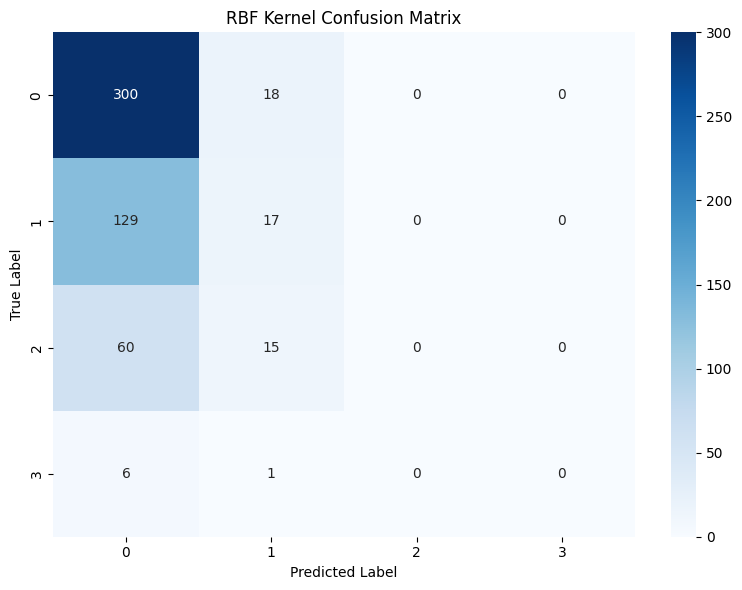

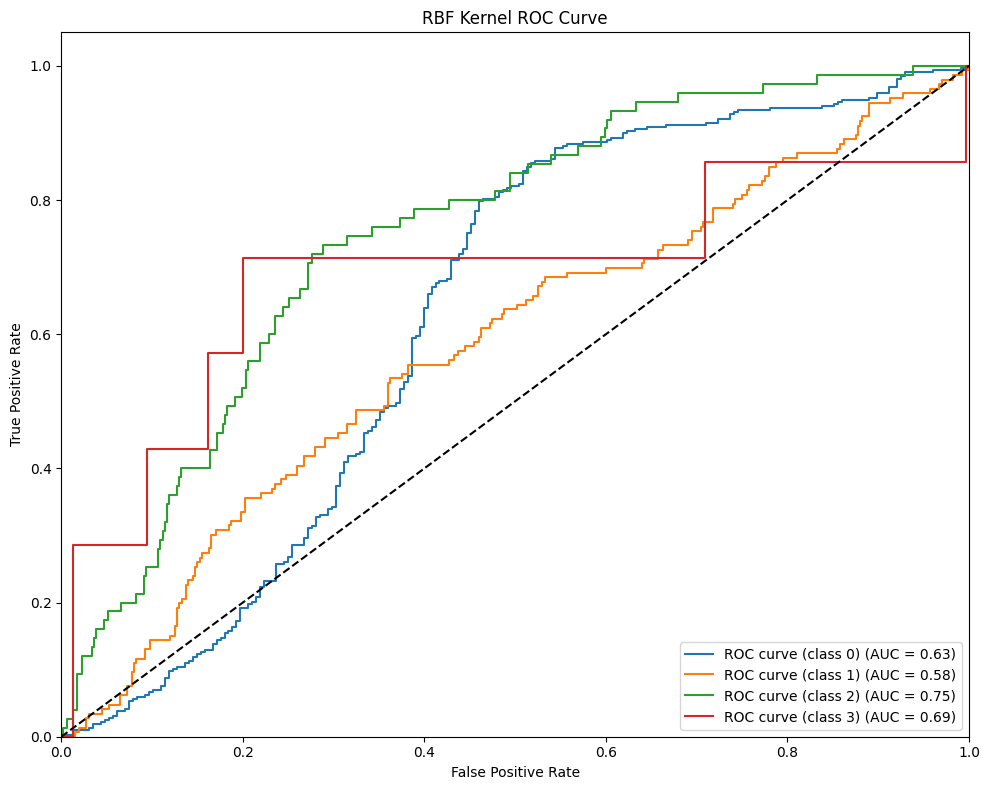

<Figure size 1000x800 with 0 Axes>

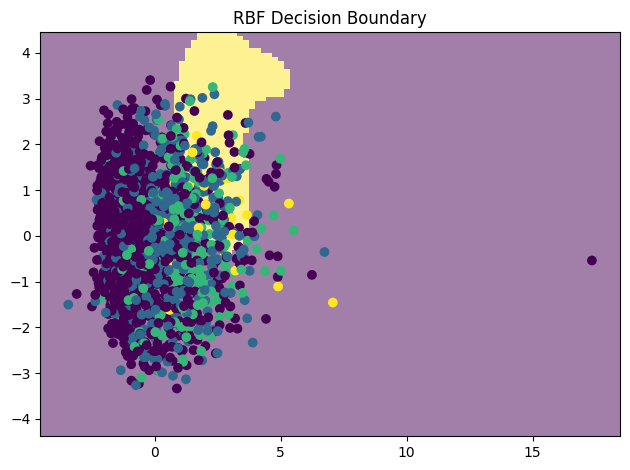

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_curve, roc_auc_score, f1_score)
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay


# Separate features and target
X = dataset.drop('sii', axis=1)
y = dataset['sii']

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for Dimensionality Reduction and Visualization
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), 'bo-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.tight_layout()
plt.show()

# Select number of components (e.g., 2 for visualization)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_2d, y, test_size=0.2, random_state=42, stratify=y
)

# Initial Class Distribution
plt.figure(figsize=(10, 5))
y.value_counts().plot(kind='bar')
plt.title('Initial Class Distribution')
plt.xlabel('SII Classes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# SVM Training with Different Kernels
kernels = ['linear', 'poly', 'rbf']
results = {}

for kernel in kernels:
    svm = SVC(kernel=kernel, probability=True)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    
    # Classification Report
    print(f"\n{kernel.upper()} Kernel Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{kernel.upper()} Kernel Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve for Multiclass
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    y_pred_proba = svm.predict_proba(X_test)
    
    plt.figure(figsize=(10, 8))
    for i in range(len(np.unique(y))):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{kernel.upper()} Kernel ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    # Decision Boundary Visualization
    plt.figure(figsize=(10, 8))
    DecisionBoundaryDisplay.from_estimator(
        svm, X_train, response_method="predict",
        plot_method="pcolormesh", shading="auto", alpha=0.5
    )
    plt.title(f'{kernel.upper()} Decision Boundary')
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
    plt.tight_layout()
    plt.show()



In [ ]:
# Optional: Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validated Score:", grid_search.best_score_)

In [ ]:
# SVM Model Characteristics
print("SVM Model Characteristics:")
print(f"Number of Support Vectors: {svm.support_vectors_.shape[0]}")
print(f"Support Vectors per Class:")
for i, count in enumerate(svm.n_support_):
    print(f"  Class {i}: {count} support vectors")

# Visualize Support Vectors
plt.figure(figsize=(10, 6))
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
            c='red', s=100, label='Support Vectors')
plt.title('Support Vectors in Feature Space')
plt.xlabel('First Feature')
plt.ylabel('Second Feature')
plt.legend()
plt.tight_layout()

In [ ]:
# Model Performance
y_pred = svm.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Save Model and Components
joblib.dump(svm, 'svm_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Model Interpretation
print("\nModel Interpretation:")
print("Decision Function Coefficients:")